In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from acgan import torch_gan
%matplotlib inline

import torch.utils.data
import torchvision.datasets as dset

import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt

import numpy as np

In [2]:
from acgan import torch_vae

## Fashion MNIST

In [4]:
# Root directory for dataset
dataroot = "~/datasets"
#dataroot = "./"

image_size = 28
batch_size = 128
workers = 4
depth = 1
img_shape = (-1, depth, image_size, image_size)

dataset = dset.FashionMNIST(dataroot, train=True, 
                            transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]), 
                            
                            target_transform=lambda x: x, download=True)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=torch.utils.data.RandomSampler(dataset, 
                                                                                replacement=True,
                                                                                num_samples=100*batch_size),
                                         shuffle=False, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

real_batch = next(iter(dataloader))

In [21]:
real_batch[1]

tensor([5, 1, 3, 7, 6, 9, 3, 1, 9, 2, 0, 3, 5, 0, 6, 9, 3, 0, 5, 9, 8, 6, 2, 4,
        7, 8, 3, 2, 6, 6, 0, 0, 2, 1, 5, 2, 8, 5, 3, 3, 2, 0, 7, 4, 5, 1, 0, 6,
        2, 1, 1, 5, 7, 9, 4, 2, 3, 9, 1, 9, 1, 8, 1, 5, 6, 1, 2, 4, 7, 7, 7, 4,
        3, 3, 9, 2, 4, 1, 3, 1, 8, 7, 6, 4, 8, 2, 0, 8, 0, 6, 1, 3, 5, 9, 5, 4,
        1, 4, 1, 9, 4, 8, 5, 1, 8, 0, 2, 9, 4, 7, 0, 9, 1, 0, 8, 9, 3, 6, 6, 1,
        4, 6, 3, 5, 1, 0, 2, 3])

In [20]:
real_batch[0].shape

torch.Size([128, 1, 28, 28])

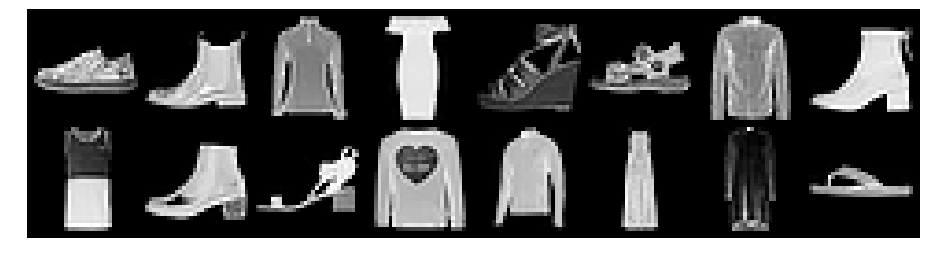

In [18]:
torch_gan.GANTrainer.grid_display(real_batch[0][:16], figsize=(16, 16));

## Build/Train Model

In [6]:
n_samples = int(np.round(dataloader.sampler.num_samples/ dataloader.batch_size))

vae_trainer = torch_vae.VAETrainer(model=torch_vae.VAE(input_size=image_size**2, z_size=2), 
                                   data_gen=dataloader, n_samples=n_samples)

In [7]:
loss_hist = vae_trainer.train(10)

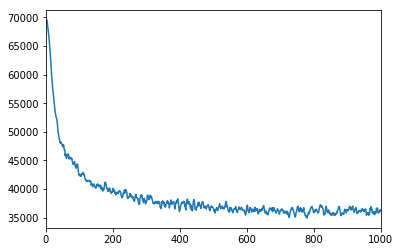

In [9]:
import pandas as pd
pd.Series(loss_hist).rolling(5).mean().plot()

****

## Examine Generation

#### Encoding real values then decoding from encodings (compression

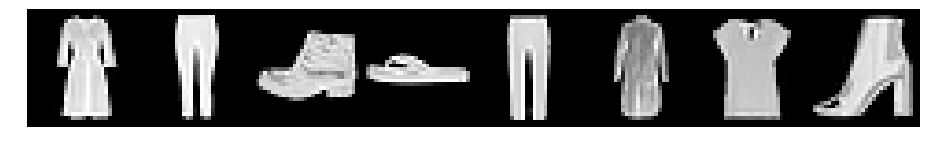

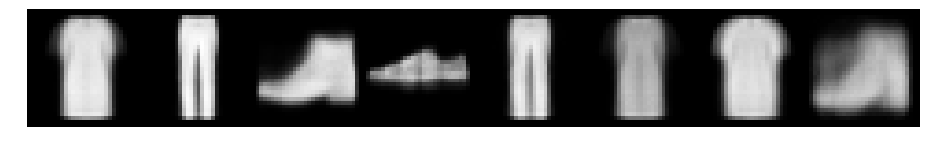

In [10]:
torch_gan.GANTrainer.grid_display(real_batch[0][:8], figsize=(16, 16));
torch_gan.GANTrainer.grid_display(vae_trainer.model(real_batch[0][:8])[0].reshape(*img_shape), 
                                  figsize=(16, 16));

#### Visualize the learned manifold
- TODO: Do like original paper and use lin spacing on unit square then transform through inverse CDF of normal

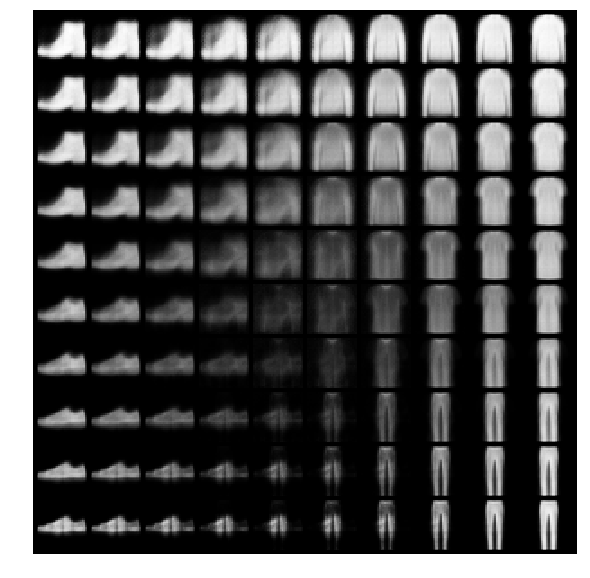

In [11]:
lin_space = (-3, 3, 10)
z_values = torch.tensor([[z0, z1] for z0 in np.linspace(*lin_space) 
                         for z1 in np.linspace(*lin_space)]).float()

latent_grid = vae_trainer.model.decode(z_values).reshape(img_shape)

torch_gan.GANTrainer.grid_display(latent_grid, nrow=lin_space[-1]);

#### Latent Space Explorer

In [12]:
from ipywidgets import widgets

def plot_from_z(z0, z1):
    _z = torch.tensor([[z0, z1]]).float()
    torch_gan.GANTrainer.grid_display(vae_trainer.model.decode(_z)[0].reshape(*img_shape), 
                                      figsize=(6, 6),
                                     title="z0=%.2f; z1=%.2f" % (z0, z1));
widgets.interact(plot_from_z, 
                 z0=widgets.FloatSlider(0., min=-10, max=10, step=0.01), 
                 z1=widgets.FloatSlider(0., min=-10, max=10, step=0.01))

interactive(children=(FloatSlider(value=0.0, description='z0', max=10.0, min=-10.0, step=0.01), FloatSlider(va…

<function __main__.plot_from_z(z0, z1)>

- IDEA: Plot Input (real) samples in their location in the latent space
    - Take real sample, pass it through encoder, sample from the resulting parameterized distribution and display the sample at that location in the chart

## Celeb Faces

In [46]:
device='cpu'
#dataroot = '/export/datasets/celeba'
dataroot = './celeba/'

image_size = 64
batch_size = 64
workers = 4
depth =3

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Random Sampling dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         sampler=torch.utils.data.RandomSampler(dataset, 
                                                                                replacement=True,
                                                                                num_samples=1000*batch_size),
                                         shuffle=False,
                                         num_workers=workers)
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

real_batch = next(iter(dataloader))

In [47]:
celeb_vae = torch_vae.VAE(input_size=depth*(image_size**2), z_size=2)

In [48]:
decoded, mu, logvar = celeb_vae(real_batch[0])

In [49]:
decoded

tensor([[0.5620, 0.6396, 0.4737,  ..., 0.6365, 0.4222, 0.6187],
        [0.5139, 0.4239, 0.4618,  ..., 0.4497, 0.5091, 0.5528],
        [0.4489, 0.4691, 0.5735,  ..., 0.5517, 0.4341, 0.5419],
        ...,
        [0.5078, 0.4953, 0.4235,  ..., 0.4841, 0.4954, 0.5625],
        [0.5138, 0.5607, 0.4915,  ..., 0.5651, 0.4583, 0.5746],
        [0.5163, 0.5571, 0.4299,  ..., 0.5592, 0.4599, 0.5927]],
       grad_fn=<SigmoidBackward>)

In [50]:
n_samples = int(np.round(dataloader.sampler.num_samples/ dataloader.batch_size))

vae_trainer = torch_vae.VAETrainer(model=celeb_vae, data_gen=dataloader,
                                   n_samples=n_samples)

In [51]:
vae_trainer.train(3)

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _fee

KeyboardInterrupt: 

In [52]:
from ipywidgets import widgets
img_shape = (-1, 3, 64, 64)

def plot_from_z(z0, z1):
    _z = torch.tensor([[z0, z1]]).float()
    torch_gan.GANTrainer.grid_display(vae_trainer.model.decode(_z)[0].reshape(*img_shape), 
                                      figsize=(6, 6),
                                     title="z0=%.2f; z1=%.2f" % (z0, z1));
widgets.interact(plot_from_z, 
                 z0=widgets.FloatSlider(0., min=-10, max=10, step=0.01), 
                 z1=widgets.FloatSlider(0., min=-10, max=10, step=0.01))

interactive(children=(FloatSlider(value=0.0, description='z0', max=10.0, min=-10.0, step=0.01), FloatSlider(va…

<function __main__.plot_from_z(z0, z1)>

***

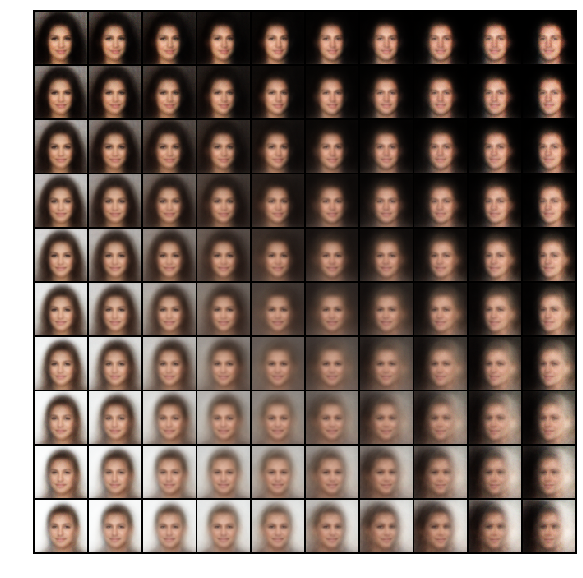

In [54]:
lin_space = (-5, 5, 10)
z_values = torch.tensor([[z0, z1] for z0 in np.linspace(*lin_space) 
                         for z1 in np.linspace(*lin_space)]).float()

latent_grid = vae_trainer.model.decode(z_values).reshape(img_shape)

torch_gan.GANTrainer.grid_display(latent_grid, nrow=lin_space[-1]);